# Your first embedding

## Exercise objectives:

- Run your first RNN for NLP
- Get a first taste of what an embedding is

<hr>

Words are not something you can easily feed to a Neural Network. For this reason, we have to convert them to something more meaningful. 

And this is exactly what _Embeddings_ are for! They map any word onto a vectorial representation (this a fancy way to represent each word with a vector ;) ). For instance, the word `dog` can be represented by the vector $(w_1, w_2, ..., w_n)$ in the embedding space, and we will learn the weights $(w_k)_k$.

So let's just do it.

# The data

❓ **Question** ❓ Let's first load the data. You don't have to understand what is going on in the function, it does not matter here.

⚠️ **Warning** ⚠️ The `load_data` function has a `percentage_of_sentences` argument. Depending on your computer, there are chances that too many sentences will make your compute slow down, or even freeze - your RAM can overflow. For that reason, **you should start with 10% of the sentences** and see if your computer handles it. Otherwise, rerun with a lower number. 

⚠️ **DISCLAIMER** ⚠️ **No need to play _who has the biggest_ (RAM) !** The idea is to get to run your models quickly to prototype. Even in real life, it is recommended that you start with a subset of your data to loop and debug quickly. So increase the number only if you are into getting the best accuracy. 

In [1]:
###########################################
### Just run this cell to load the data ###
###########################################

import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def load_data(percentage_of_sentences=None):
    train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], batch_size=-1, as_supervised=True)

    train_sentences, y_train = tfds.as_numpy(train_data)
    test_sentences, y_test = tfds.as_numpy(test_data)
    
    # Take only a given percentage of the entire data
    if percentage_of_sentences is not None:
        assert(percentage_of_sentences> 0 and percentage_of_sentences<=100)
        
        len_train = int(percentage_of_sentences/100*len(train_sentences))
        train_sentences, y_train = train_sentences[:len_train], y_train[:len_train]
  
        len_test = int(percentage_of_sentences/100*len(test_sentences))
        test_sentences, y_test = test_sentences[:len_test], y_test[:len_test]
    
    X_train = [text_to_word_sequence(_.decode("utf-8")) for _ in train_sentences]
    X_test = [text_to_word_sequence(_.decode("utf-8")) for _ in test_sentences]
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data(percentage_of_sentences=10)

2023-12-22 14:26:10.610637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBT1IQV/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBT1IQV/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteBT1IQV/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


2023-12-22 14:33:32.961777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now that you have loaded the data, let's check it out!

❓ **Question** ❓ You can play with the data here. In particular, `X_train` and `X_test` are lists of sentences. Let's print some of them, with their respective label stored in `y_train` and `y_test`.

In [2]:
# Print some sample sentences with their labels
for i in range(5):  # You can change the range if you want to see more or fewer examples
    print("Train Sentence:", ' '.join(X_train[i]))
    print("Train Label:", y_train[i])
    print()

for i in range(5):  # Same for test sentences
    print("Test Sentence:", ' '.join(X_test[i]))
    print("Test Label:", y_test[i])
    print()

Train Sentence: this was an absolutely terrible movie don't be lured in by christopher walken or michael ironside both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the columbian rebels were making their cases for revolutions maria conchita alonso appeared phony and her pseudo love affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actor's like christopher walken's good name i could barely sit through it
Train Label: 0

Train Sentence: i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the sette and having just eaten a lot however on this occasion i fell asleep because the film was rubbis

**LABELS**: the task is a binary classification problem:
- label 0️⃣ corresponds to a <font color=red>negative</font> movie review
- label 1️⃣ corresponds to a <font color=green>positive</font> movie review

**INPUTS**: 
- 🧹 The data has been partially cleaned! So you don't have to worry about it in this exercise. 
- ❗️ But don't forget this step in real-life challenges. 

Remember that words are not computer-compatible materials? You have to tokenize them!

❓ **Question** ❓ Run the following cell to tokenize your sentences

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer

# This initializes a Keras utilities that does all the tokenization for you
tokenizer = Tokenizer()

# The tokenization learns a dictionary that maps a token (integer) to each word
# It can be done only on the train set - we are not supposed to know the test set!
# This tokenization also lowercases your words, apply some filters, and so on - you can check the doc if you want
tokenizer.fit_on_texts(X_train)
    
# We apply the tokenization to the train and test set
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

❓ **Question** ❓ Print some of the tokenized sentences to be sure you got what you expected

In [4]:
# Print some sample tokenized sentences
for i in range(5):  # You can change the range if you want to see more or fewer examples
    print("Original Train Sentence:", ' '.join(X_train[i]))
    print("Tokenized Train Sentence:", X_train_token[i])
    print()

for i in range(5):  # Same for test sentences
    print("Original Test Sentence:", ' '.join(X_test[i]))
    print("Tokenized Test Sentence:", X_test_token[i])
    print()

Original Train Sentence: this was an absolutely terrible movie don't be lured in by christopher walken or michael ironside both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the columbian rebels were making their cases for revolutions maria conchita alonso appeared phony and her pseudo love affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actor's like christopher walken's good name i could barely sit through it
Tokenized Train Sentence: [11, 13, 33, 422, 402, 18, 91, 27, 6893, 8, 31, 1311, 4504, 39, 539, 8007, 194, 24, 75, 161, 17, 11, 228, 336, 27, 68, 252, 203, 8, 468, 58, 68, 75, 108, 98, 21, 4165, 11, 1418, 694, 695, 11, 18, 6, 33, 389, 6065, 204, 2345, 487, 1, 86, 928, 140, 69, 

The dictionary that maps each word to a token can be accessed with `tokenizer.word_index`
    
❓ **Question** ❓ Add a `vocab_size` variable that stores the number of different words (=tokens) in the train set. This is called the _size of the vocabulary_.

In [5]:
# Vocabulary size
vocab_size = len(tokenizer.word_index)

print("Size of Vocabulary:", vocab_size)

Size of Vocabulary: 30419


Your `X_train_token` and `X_test_token` contain sequences of different lengths.

<img src="padding.png" alt='Word2Vec' width="700px" />

However, a neural network has to have a tensor as input. For this reason, you have to pad your data.

❓ **Question** ❓  Pad your data with the `pad_sequences` function (documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences)). Do not forget about the `dtype` and `padding` keywords (but do not use `maxlen` here).

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad the sequences
X_train_padded = pad_sequences(X_train_token, dtype='int32', padding='pre')
X_test_padded = pad_sequences(X_test_token, dtype='int32', padding='pre')

# Print some information about the padded data
print("Padded Train Sequence:", X_train_padded.shape)
print("Padded Test Sequence:", X_test_padded.shape)

Padded Train Sequence: (2500, 1164)
Padded Test Sequence: (2500, 988)


# The RNN

Let's now feed this data to a Recurrent Neural Network.

❓ **Question** ❓ Write a model that has:
- an embedding layer whose `input_dim` is the size of your vocabulary (= your `vocab_size`), and whose `output_dim` is the size of the embedding space you want to have
- a RNN (SimpleRNN, LSTM, GRU) layer
- a Dense layer
- an output layer

⚠️ **Warning** ⚠️ Here, you don't need a masking layer. Why? Because `layers.Embedding` has a argument to do that directly, which you have to set with `mask_zero=True`. That also means that your data **HAS TO** be padded with **0** (which is the default behavior). See the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding#example_2) to understand how it **impacts** the `input_dim`.

<details>
    <summary>💡 Hint</summary>

`input_dim` should equal size of vocabulary + 1

</details>

Compile it with the appropriate arguments

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Choose the size of your embedding space
embedding_size = 50  # Example value, you can adjust this

# Create the model
model = Sequential()

# Add an Embedding layer
model.add(Embedding(input_dim=vocab_size + 1, output_dim=embedding_size, mask_zero=True))

# Add an RNN layer - using LSTM in this example
model.add(LSTM(64))  # You can adjust the number of units

# Add a Dense layer
model.add(Dense(32, activation='relu'))  # You can adjust the number of neurons and activation function

# Add an output layer - assuming binary classification
model.add(Dense(1, activation='sigmoid'))  # Use 'softmax' for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Adjust loss and metrics as per your task

❓ **Question** ❓ Look at the number of parameters in your RNN. 

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          1521000   
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,552,553
Trainable params: 1,552,553
Non-trainable params: 0
_________________________________________________________________


❓ Double-check that the number of parameters in your embedding layer is equal to the (number of words in your vocabulary + 1 for the masking value) $\times$  the dimension of your embedding.

In [12]:
embedding_params = (vocab_size + 1) * embedding_size

❓ **Question** ❓ Start fitting your model with 20 epochs, with an early stopping criterion whose patience is equal to 4.

⚠️ **Warning** ⚠️ You might see that it takes a lot of time! 

**So stop it after a couple of iterations!**

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

# Assuming X_train_padded, y_train, X_test_padded, and y_test are your training and testing data
# Define the EarlyStopping callback
early_stopping = EarlyStopping(patience=4)

# Fit the model
history = model.fit(X_train_padded, y_train,
                    epochs=20,
                    validation_data=(X_test_padded, y_test),
                    callbacks=[early_stopping])

Epoch 1/20
79/79 [==============================] - 54s 630ms/step - loss: 0.6663 - accuracy: 0.5904 - val_loss: 0.5314 - val_accuracy: 0.7644
Epoch 2/20
79/79 [==============================] - 48s 607ms/step - loss: 0.3238 - accuracy: 0.8768 - val_loss: 0.3872 - val_accuracy: 0.8284
Epoch 3/20
79/79 [==============================] - 49s 615ms/step - loss: 0.1943 - accuracy: 0.9272 - val_loss: 0.5351 - val_accuracy: 0.7292
Epoch 4/20
79/79 [==============================] - 48s 609ms/step - loss: 0.1078 - accuracy: 0.9656 - val_loss: 0.5116 - val_accuracy: 0.8080
Epoch 5/20
79/79 [==============================] - 48s 607ms/step - loss: 0.0145 - accuracy: 0.9968 - val_loss: 0.6110 - val_accuracy: 0.8208
Epoch 6/20
79/79 [==============================] - 48s 606ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.7671 - val_accuracy: 0.8224


Let's not waste too much time just staring at our screen or having coffees. It is too early to start having breaks ;)

❓ **Question** ❓ We will reduce the computational time. To start, let's first look at how many words there are in the different sentences of your train set (Just run the following cell).

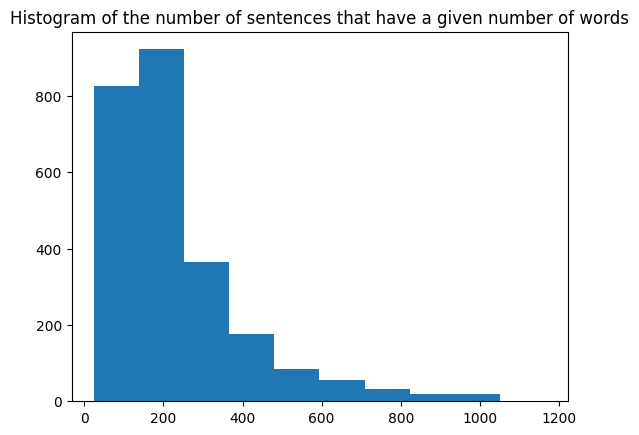

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_hist(X):
    len_ = [len(_) for _ in X]
    plt.hist(len_)
    plt.title('Histogram of the number of sentences that have a given number of words')
    plt.show()
    
plot_hist(X_train)


You will probably see that 90 to 95% of your sentences have less than 300 words. And very few have more than 1000.

However, as you didn't use `maxlen` in your padding above, your input tensor has a dimension equal to the length of the sentence that has the maximum number of words.

Now, let's look at how this affects the padding: 


<img src="tensor_size.png" alt='Word2Vec' width="700px" />

Because of a few of very long sentences, one dimension of your tensor is equal to around 1000. However, most of the sentences with ~200 words have just padded values that are useless.

So your tensor is mostly useless information, which still adds time to the training process.

But what if you pad the data to a maximum length (`maxlen`) of say 200 (words)?
- First, that would increase the convergence and you would not need to stare at your screen while waiting for the algorithm to converge
- But in essence, do you really lose that much information? Do you think that you often need more than 200 words (up to 1000) to tell whether or not a sentence is positive of negative?

❓ **Question** ❓ For all these reasons, re-do your padding using the `maxlen` keyword and retrain the model!  See how much faster it is now - without hurting the performance ;)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Re-pad the sequences with a maximum length of 200
maxlen = 200
X_train_padded = pad_sequences(X_train_token, maxlen=maxlen, dtype='int32', padding='pre')
X_test_padded = pad_sequences(X_test_token, maxlen=maxlen, dtype='int32', padding='pre')

# Assuming your model is already defined as 'model'
# Fit the model with the re-padded data
history = model.fit(X_train_padded, y_train,
                    epochs=20,
                    validation_data=(X_test_padded, y_test),
                    callbacks=[early_stopping])

Epoch 1/20
79/79 [==============================] - 15s 147ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.8138 - val_accuracy: 0.8176
Epoch 2/20
79/79 [==============================] - 10s 127ms/step - loss: 4.9580e-04 - accuracy: 1.0000 - val_loss: 0.9495 - val_accuracy: 0.8140
Epoch 3/20
79/79 [==============================] - 10s 131ms/step - loss: 2.9799e-04 - accuracy: 1.0000 - val_loss: 1.0055 - val_accuracy: 0.8104
Epoch 4/20
79/79 [==============================] - ETA: 0s - loss: 2.1571e-04 - accuracy: 1.0000

🏁 Nice, you are now able to use `Tokenizer` and `pad_sequences`

💾 Don't forget to git add/commit/push your notebook...

🚀 ... and move on to the next challenge!